In [1]:
import requests
import pandas as pd
import io
import urllib.parse

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

In [ ]:
user = ""
password = ""

In [3]:
q = "SELECT * FROM connections"
encoded_q = urllib.parse.quote(q)
r = requests.get(
    f"http://matrix.sikp.xyz:9000/exp?query={encoded_q}&limit=1",
    auth=(user, password)
)
raw = r.text
df = pd.read_csv(io.StringIO(raw), parse_dates=["timestamp"])

In [4]:
q = "SELECT * FROM connections"
encoded_q = urllib.parse.quote(q)
batch = 0
all_data = []
while True:
    r = requests.get(
    f"http://matrix.sikp.xyz:9000/exp?query={encoded_q}&limit={batch},{batch+1000}",
    auth=(user, password)
    )
    raw = r.text
    df = pd.read_csv(io.StringIO(raw), parse_dates=["timestamp"])
    batch += 1000
    all_data.append(df)
    if len(df) < 1000:
        break

df = pd.concat(all_data, ignore_index=True)


In [5]:
df

,receiver,transmitter,timestamp
0,edb5c615-33c9-423d-8ef1-2b575dfaecac,340a33eb-ab2f-48c5-844d-a65570723a0d,2025-08-13 14:32:22.845391+00:00
1,31fa4077-11be-4e31-aaa3-b6a85a08f706,95d7b911-1c4e-4a71-b669-9cb838018663,2025-08-13 14:32:23.630786+00:00
2,548dcd41-c18b-4828-9dda-bac06dca6665,60300bef-0aa0-4abe-bdf0-11f348be9a07,2025-08-13 14:32:24.834205+00:00
3,548dcd41-c18b-4828-9dda-bac06dca6665,340a33eb-ab2f-48c5-844d-a65570723a0d,2025-08-13 14:32:24.883538+00:00
4,66fffc05-4e9b-4381-b8ab-8fc7a42b6704,6ab18db7-c83a-4755-ad1c-d670a72b0ea1,2025-08-13 14:32:25.641882+00:00
...,...,...,...
1783,5a5da229-4c7c-422a-b906-a1c3a9c17d6a,c2103420-7e4d-429a-8610-419ef7b6901d,2025-08-13 14:49:58.967558+00:00
1784,f9b9394b-7d21-45e3-bb70-e593660c456d,6563ccf9-b157-4eef-ad37-93eb72648a35,2025-08-13 14:49:59.402789+00:00
1785,f9b9394b-7d21-45e3-bb70-e593660c456d,023ce283-bd59-412d-b812-7c69da1fddac,2025-08-13 14:49:59.480628+00:00
1786,bd12441b-07a7-4da8-8118-7d8032c0bb9e,22c0f93f-4734-4974-b49c-28a5eff854ed,2025-08-13 14:49:59.691235+00:00


In [6]:
class IoTInteractionAnalyzer:
    def __init__(self, df):
        self.df = df.copy()
        self.df['timestamp'] = pd.to_datetime(self.df['timestamp'])
        self.df = self.df.sort_values('timestamp').reset_index(drop=True)
        
        # Parametri configurabili
        self.max_gap_seconds = 30  # Soglia per considerare interrotta un'interazione
        self.min_interaction_duration = 5  # Durata minima per considerare valida un'interazione
        
    def preprocess_interactions(self):
        """
        Calcola le durate delle interazioni e gestisce la bidirezionalità
        """
        print("🔄 Preprocessing delle interazioni...")
        
        # Crea coppie ordinate per evitare duplicati (A-B = B-A)
        self.df['pair'] = self.df.apply(
            lambda x: tuple(sorted([x['receiver'], x['transmitter']])), axis=1
        )
        
        interactions = []
        
        for pair in self.df['pair'].unique():
            pair_data = self.df[self.df['pair'] == pair].sort_values('timestamp')
            
            if len(pair_data) == 0:
                continue
                
            current_interaction = {
                'device_1': pair[0],
                'device_2': pair[1],
                'start_time': pair_data.iloc[0]['timestamp'],
                'detections': [pair_data.iloc[0]['timestamp']]
            }
            
            last_timestamp = pair_data.iloc[0]['timestamp']
            
            for i in range(1, len(pair_data)):
                row = pair_data.iloc[i]
                time_gap = (row['timestamp'] - last_timestamp).total_seconds()
                
                if time_gap <= self.max_gap_seconds:
                    # Continua la stessa interazione
                    current_interaction['detections'].append(row['timestamp'])
                else:
                    # Fine dell'interazione corrente
                    if len(current_interaction['detections']) > 0:
                        current_interaction['end_time'] = max(current_interaction['detections'])
                        current_interaction['duration'] = (
                            current_interaction['end_time'] - current_interaction['start_time']
                        ).total_seconds()
                        current_interaction['detection_count'] = len(current_interaction['detections'])
                        
                        if current_interaction['duration'] >= self.min_interaction_duration:
                            interactions.append(current_interaction.copy())
                    
                    # Inizia nuova interazione
                    current_interaction = {
                        'device_1': pair[0],
                        'device_2': pair[1],
                        'start_time': row['timestamp'],
                        'detections': [row['timestamp']]
                    }
                
                last_timestamp = row['timestamp']
            
            # Non dimenticare l'ultima interazione
            if len(current_interaction['detections']) > 0:
                current_interaction['end_time'] = max(current_interaction['detections'])
                current_interaction['duration'] = (
                    current_interaction['end_time'] - current_interaction['start_time']
                ).total_seconds()
                current_interaction['detection_count'] = len(current_interaction['detections'])
                
                if current_interaction['duration'] >= self.min_interaction_duration:
                    interactions.append(current_interaction)
        
        self.interactions_df = pd.DataFrame(interactions)
        print(f"✅ Trovate {len(self.interactions_df)} interazioni valide")
        return self.interactions_df
    
    def calculate_device_statistics(self):
        """
        Calcola statistiche per ogni dispositivo (versione blindata e definitiva).
        """
        print("📊 Calcolando statistiche per dispositivo...")
        
        if not hasattr(self, 'interactions_df'):
            print("⚠️ 'interactions_df' non trovato. Esegui prima preprocess_interactions().")
            self.device_stats_df = pd.DataFrame()
            return self.device_stats_df

        device_stats = {}
        all_devices = set(self.df['receiver'].unique()) | set(self.df['transmitter'].unique())
        
        for device in all_devices:
            device_interactions = self.interactions_df[
                (self.interactions_df['device_1'] == device) | 
                (self.interactions_df['device_2'] == device)
            ]
            
            detections_as_receiver = len(self.df[self.df['receiver'] == device])
            detections_as_transmitter = len(self.df[self.df['transmitter'] == device])
            
            contacts = set()
            for _, interaction in device_interactions.iterrows():
                contacts.add(interaction['device_2'] if interaction['device_1'] == device else interaction['device_1'])
            
            device_activity = self.df[(self.df['receiver'] == device) | (self.df['transmitter'] == device)]
            first_activity = device_activity['timestamp'].min() if not device_activity.empty else pd.NaT
            last_activity = device_activity['timestamp'].max() if not device_activity.empty else pd.NaT
            
            device_stats[device] = {
                'total_interactions': len(device_interactions),
                'unique_contacts': len(contacts),
                'total_interaction_time': device_interactions['duration'].sum(),
                'avg_interaction_duration': device_interactions['duration'].mean(),
                'detections_as_receiver': detections_as_receiver,
                'detections_as_transmitter': detections_as_transmitter,
                'total_detections': detections_as_receiver + detections_as_transmitter,
                'first_activity': first_activity,
                'last_activity': last_activity
            }
        
        self.device_stats_df = pd.DataFrame(device_stats).T

        # <<< CORREZIONE BLINDATA >>>
        if not self.device_stats_df.empty:
            # 1. Gestisci le colonne numeriche
            numeric_cols = ['total_interactions', 'unique_contacts', 'total_interaction_time',
                            'avg_interaction_duration', 'detections_as_receiver',
                            'detections_as_transmitter', 'total_detections']
            self.device_stats_df[numeric_cols] = self.device_stats_df[numeric_cols].apply(pd.to_numeric, errors='coerce').fillna(0)
            
            # Converti in interi le colonne che devono esserlo
            int_cols = ['total_interactions', 'unique_contacts', 'detections_as_receiver', 
                        'detections_as_transmitter', 'total_detections']
            self.device_stats_df[int_cols] = self.device_stats_df[int_cols].astype(int)

            # 2. FORZA LA CONVERSIONE DELLE COLONNE DI DATE
            # Questa è la parte cruciale che risolve l'errore.
            datetime_cols = ['first_activity', 'last_activity']
            for col in datetime_cols:
                self.device_stats_df[col] = pd.to_datetime(self.device_stats_df[col], errors='coerce')

        return self.device_stats_df
    
    def create_interaction_network(self):
        """
        Crea il grafo pesato delle interazioni
        """
        print("🕸️ Creando rete delle interazioni...")
        
        if len(self.interactions_df) == 0:
            print("⚠️ Nessuna interazione trovata, creando grafo vuoto")
            self.network = nx.Graph()
            self.network_data = pd.DataFrame()
            return self.network
        
        # Aggrega per coppia di dispositivi
        network_data = self.interactions_df.groupby(['device_1', 'device_2']).agg({
            'duration': 'sum',
            'detection_count': 'sum',
            'start_time': 'count'  # Numero di sessioni di interazione
        }).rename(columns={'start_time': 'interaction_sessions'}).reset_index()
        
        # Crea grafo
        G = nx.Graph()
        
        # Aggiungi tutti i dispositivi come nodi (anche quelli senza interazioni)
        all_devices = set(self.df['receiver'].unique()) | set(self.df['transmitter'].unique())
        G.add_nodes_from(all_devices)
        
        # Aggiungi edges per le interazioni
        for _, row in network_data.iterrows():
            G.add_edge(
                row['device_1'], 
                row['device_2'],
                weight=row['duration'],
                detection_count=row['detection_count'],
                interaction_sessions=row['interaction_sessions'],
                avg_session_duration=row['duration'] / row['interaction_sessions']
            )
        
        self.network = G
        self.network_data = network_data
        return G
    
    def analyze_network_metrics(self):
        """
        Calcola metriche di network analysis con gestione di grafi disconnessi
        """
        print("📈 Calcolando metriche di rete...")
        
        if not hasattr(self, 'network'):
            self.create_interaction_network()
        
        metrics = {}
        
        # Metriche globali
        num_nodes = self.network.number_of_nodes()
        num_edges = self.network.number_of_edges()
        is_connected = nx.is_connected(self.network)
        
        metrics['global'] = {
            'num_nodes': num_nodes,
            'num_edges': num_edges,
            'density': nx.density(self.network) if num_nodes > 1 else 0,
            'avg_clustering': nx.average_clustering(self.network) if num_nodes > 0 else 0,
            'is_connected': is_connected,
            'num_connected_components': nx.number_connected_components(self.network)
        }
        
        # Analisi delle componenti connesse
        connected_components = list(nx.connected_components(self.network))
        if connected_components:
            largest_cc = max(connected_components, key=len)
            metrics['global']['largest_component_size'] = len(largest_cc)
            metrics['global']['largest_component_percentage'] = len(largest_cc) / num_nodes * 100 if num_nodes > 0 else 0
            
            # Metriche per la componente più grande
            if len(largest_cc) > 1:
                largest_subgraph = self.network.subgraph(largest_cc)
                if nx.is_connected(largest_subgraph):
                    metrics['global']['diameter_largest_component'] = nx.diameter(largest_subgraph)
                    metrics['global']['avg_path_length_largest_component'] = nx.average_shortest_path_length(largest_subgraph)
        
        # Se il grafo è completamente connesso
        if is_connected and num_nodes > 1:
            metrics['global']['diameter'] = nx.diameter(self.network)
            metrics['global']['avg_path_length'] = nx.average_shortest_path_length(self.network)
        
        # Metriche per nodo (gestiscono automaticamente grafi disconnessi)
        if num_nodes > 0:
            degree_centrality = nx.degree_centrality(self.network)
            betweenness_centrality = nx.betweenness_centrality(self.network)
            closeness_centrality = nx.closeness_centrality(self.network)
            
            # Eigenvector centrality - con gestione errori per grafi disconnessi
            try:
                eigenvector_centrality = nx.eigenvector_centrality(self.network, max_iter=1000, tol=1e-06)
            except (nx.PowerIterationFailedConvergence, nx.NetworkXError):
                print("⚠️ Eigenvector centrality non convergente (normale per grafi disconnessi)")
                try:
                    # Prova con parametri più rilassati
                    eigenvector_centrality = nx.eigenvector_centrality(self.network, max_iter=500, tol=1e-04)
                except:
                    # Se ancora non converge, usa valori basati su degree centrality
                    print("   → Uso approssimazione basata su degree centrality")
                    max_degree = max(degree_centrality.values()) if degree_centrality else 1
                    eigenvector_centrality = {node: deg/max_degree for node, deg in degree_centrality.items()}
            
            # PageRank come alternativa robusta (funziona sempre)
            try:
                pagerank_centrality = nx.pagerank(self.network, weight='weight', alpha=0.85, max_iter=1000)
            except:
                pagerank_centrality = {node: 1.0/num_nodes for node in self.network.nodes()}
            
            node_metrics = pd.DataFrame({
                'device': list(degree_centrality.keys()),
                'degree_centrality': list(degree_centrality.values()),
                'betweenness_centrality': list(betweenness_centrality.values()),
                'closeness_centrality': list(closeness_centrality.values()),
                'eigenvector_centrality': list(eigenvector_centrality.values()),
                'pagerank_centrality': list(pagerank_centrality.values())
            })
        else:
            node_metrics = pd.DataFrame()
        
        metrics['nodes'] = node_metrics
        self.network_metrics = metrics
        return metrics
    
    def detect_communities(self):
        """
        Rileva comunità nella rete (gestisce grafi disconnessi)
        """
        print("👥 Rilevando comunità...")
        
        if not hasattr(self, 'network'):
            self.create_interaction_network()
        
        if self.network.number_of_edges() == 0:
            print("   ⚠️ Nessun edge nel grafo, ogni nodo è una comunità isolata")
            communities = [frozenset([node]) for node in self.network.nodes()]
        else:
            # Algoritmo di Louvain per community detection (gestisce grafi disconnessi)
            try:
                communities = nx.community.louvain_communities(self.network, weight='weight', seed=42)
            except:
                # Fallback: usa le componenti connesse come comunità
                print("   → Uso componenti connesse come comunità")
                communities = [frozenset(component) for component in nx.connected_components(self.network)]
        
        community_dict = {}
        for i, community in enumerate(communities):
            for node in community:
                community_dict[node] = i
        
        self.communities = communities
        self.community_dict = community_dict
        return communities
    
    def plot_interaction_timeline(self):
        """
        Crea timeline delle interazioni
        """
        print("⏱️ Creando timeline delle interazioni...")
        
        fig = make_subplots(
            rows=2, cols=1,
            subplot_titles=['Numero di Rilevazioni per Ora', 'Durata Interazioni nel Tempo'],
            vertical_spacing=0.1
        )
        
        # Rilevazioni per ora
        hourly_data = self.df.copy()
        hourly_data['hour'] = hourly_data['timestamp'].dt.floor('H')
        hourly_counts = hourly_data.groupby('hour').size().reset_index(name='detections')
        
        fig.add_trace(
            go.Scatter(
                x=hourly_counts['hour'],
                y=hourly_counts['detections'],
                mode='lines+markers',
                name='Rilevazioni/Ora'
            ),
            row=1, col=1
        )
        
        # Durata interazioni nel tempo
        if hasattr(self, 'interactions_df') and len(self.interactions_df) > 0:
            fig.add_trace(
                go.Scatter(
                    x=self.interactions_df['start_time'],
                    y=self.interactions_df['duration'],
                    mode='markers',
                    name='Durata Interazioni',
                    marker=dict(
                        size=self.interactions_df['detection_count'],
                        sizemode='diameter',
                        sizeref=2.*max(self.interactions_df['detection_count'])/(20.**2) if len(self.interactions_df) > 0 else 1,
                        sizemin=4
                    )
                ),
                row=2, col=1
            )
        
        fig.update_layout(height=800, title_text="Timeline delle Interazioni IoT")
        fig.show()
    
    def plot_network_graph(self):
        """
        Visualizza il grafo delle interazioni (gestisce grafi disconnessi)
        """
        print("🎨 Creando visualizzazione della rete...")
        
        if not hasattr(self, 'network'):
            self.create_interaction_network()
        
        if self.network.number_of_nodes() == 0:
            print("   ⚠️ Nessun nodo nel grafo")
            return
        
        # Layout del grafo
        try:
            if nx.is_connected(self.network):
                pos = nx.spring_layout(self.network, k=1, iterations=50, seed=42)
            else:
                pos = nx.spring_layout(self.network, k=3, iterations=50, seed=42)
        except:
            pos = {node: (np.random.random(), np.random.random()) for node in self.network.nodes()}
        
        # Preparazione dati per Plotly
        edge_x, edge_y, edge_weights = [], [], []
        for edge in self.network.edges():
            x0, y0 = pos[edge[0]]
            x1, y1 = pos[edge[1]]
            edge_x.extend([x0, x1, None])
            edge_y.extend([y0, y1, None])
            edge_weights.append(self.network[edge[0]][edge[1]].get('weight', 1))
        
        edge_trace = go.Scatter(
            x=edge_x, y=edge_y,
            line=dict(width=0.8, color='#888'),
            hoverinfo='none',
            mode='lines'
        )
        
        # Nodes
        node_x, node_y, node_text, node_size, node_colors = [], [], [], [], []
        for node in self.network.nodes():
            x, y = pos[node]
            node_x.append(x)
            node_y.append(y)
            
            degree = self.network.degree(node)
            total_weight = sum(self.network[node][neighbor].get('weight', 0) for neighbor in self.network.neighbors(node))
            community_id = self.community_dict.get(node, 0) if hasattr(self, 'community_dict') else 0
            
            node_text.append(f"Device: {node}<br>Connessioni: {degree}<br>Tempo totale: {total_weight:.1f}s<br>Comunità: {community_id}")
            node_size.append(max(10, 10 + degree * 3))
            node_colors.append(community_id)
        
        node_trace = go.Scatter(
            x=node_x, y=node_y,
            mode='markers+text',
            hoverinfo='text',
            text=[node[:8] + '...' if len(node) > 8 else node for node in self.network.nodes()],
            textposition="middle center",
            hovertext=node_text,
            marker=dict(
                showscale=True,
                colorscale='viridis',  # Correzione 1
                color=node_colors,
                size=node_size,
                colorbar=dict(thickness=15, len=0.5, x=1.02, title="Comunità"),
                line=dict(width=2, color='black')
            )
        )
        
        # Informazioni sulla connettività
        connectivity_info = f"Componenti connesse: {nx.number_connected_components(self.network)}"
        if hasattr(self, 'network_metrics'):
            largest_comp_size = self.network_metrics['global'].get('largest_component_size', 0)
            connectivity_info += f"<br>Componente più grande: {largest_comp_size} nodi"
        
        # Layout del plot
        fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        # Correzione 2: 'title' è ora un dizionario
                        title=dict(
                            text=f'Rete delle Interazioni IoT<br><sub>{connectivity_info}</sub>',
                            font=dict(size=16)
                        ),
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20, l=5, r=5, t=60),
                        annotations=[dict(
                            text="Colore = comunità, dimensione = numero connessioni",
                            showarrow=False,
                            xref="paper", yref="paper",
                            x=0.005, y=-0.002,
                            xanchor='left', yanchor='bottom',
                            font=dict(color='gray', size=12)
                        )],
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                    )
        fig.show()
    
    def analyze_connectivity(self):
        """
        Analizza la connettività del grafo in dettaglio
        """
        print("🔗 Analisi dettagliata della connettività...")
        
        if not hasattr(self, 'network'):
            self.create_interaction_network()
        
        components = list(nx.connected_components(self.network))
        
        print(f"   📊 Componenti connesse: {len(components)}")
        
        if len(components) > 1:
            # Analizza le componenti
            component_sizes = [len(comp) for comp in components]
            component_sizes.sort(reverse=True)
            
            print(f"   🏆 Componente più grande: {component_sizes[0]} nodi ({component_sizes[0]/self.network.number_of_nodes()*100:.1f}%)")
            print(f"   📈 Distribuzione dimensioni componenti: {component_sizes[:5]}...")
            
            # Nodi isolati
            isolated_nodes = [comp for comp in components if len(comp) == 1]
            if isolated_nodes:
                print(f"   🏝️ Nodi isolati: {len(isolated_nodes)} ({len(isolated_nodes)/self.network.number_of_nodes()*100:.1f}%)")
        
        # Densità locale per componente
        for i, component in enumerate(components[:3]):  # Solo prime 3 componenti
            if len(component) > 1:
                subgraph = self.network.subgraph(component)
                local_density = nx.density(subgraph)
                print(f"   🕸️ Densità componente {i+1}: {local_density:.3f}")
    
    def generate_summary_report(self):
        """
        Genera report riassuntivo
        """
        print("\n" + "="*70)
        print("📋 REPORT RIASSUNTIVO ANALISI INTERAZIONI IoT")
        print("="*70)
        
        # Statistiche globali
        total_detections = len(self.df)
        unique_devices = len(set(self.df['receiver'].unique()) | set(self.df['transmitter'].unique()))
        event_duration = (self.df['timestamp'].max() - self.df['timestamp'].min()).total_seconds() / 3600
        
        print(f"\n🔍 STATISTICHE GENERALI:")
        print(f"   • Rilevazioni totali: {total_detections:,}")
        print(f"   • Dispositivi unici: {unique_devices}")
        print(f"   • Durata evento: {event_duration:.1f} ore")
        print(f"   • Media rilevazioni/ora: {total_detections/event_duration:.1f}")
        
        if hasattr(self, 'interactions_df') and len(self.interactions_df) > 0:
            print(f"\n🤝 INTERAZIONI:")
            print(f"   • Interazioni totali: {len(self.interactions_df)}")
            print(f"   • Durata media: {self.interactions_df['duration'].mean():.1f} secondi")
            print(f"   • Interazione più lunga: {self.interactions_df['duration'].max():.1f} secondi")
            print(f"   • Tempo totale di interazione: {self.interactions_df['duration'].sum()/60:.1f} minuti")
        
        if hasattr(self, 'network_metrics'):
            print(f"\n🕸️ RETE SOCIALE:")
            metrics = self.network_metrics['global']
            print(f"   • Nodi: {metrics['num_nodes']}, Archi: {metrics['num_edges']}")
            print(f"   • Densità rete: {metrics['density']:.3f}")
            print(f"   • Clustering medio: {metrics['avg_clustering']:.3f}")
            print(f"   • Componenti connesse: {metrics['num_connected_components']}")
            
            if metrics['num_connected_components'] > 1:
                print(f"   • Componente più grande: {metrics.get('largest_component_size', 0)} nodi "
                      f"({metrics.get('largest_component_percentage', 0):.1f}%)")
            
            if metrics['is_connected']:
                print(f"   • Diametro: {metrics['diameter']}")
                print(f"   • Lunghezza media percorso: {metrics['avg_path_length']:.2f}")
            
            if hasattr(self, 'communities'):
                print(f"   • Comunità rilevate: {len(self.communities)}")
        
        # Top dispositivi
        if hasattr(self, 'device_stats_df') and len(self.device_stats_df) > 0:
            print(f"\n🏆 TOP DISPOSITIVI:")
            top_social = self.device_stats_df.nlargest(min(3, len(self.device_stats_df)), 'unique_contacts')
            for i, (device, stats) in enumerate(top_social.iterrows()):
                print(f"   {i+1}. {device[:12]}... - {int(stats['unique_contacts'])} contatti, "
                      f"{stats['total_interaction_time']:.0f}s di interazione")
        
        # Analisi connettività
        if hasattr(self, 'network'):
            self.analyze_connectivity()
        
        print("\n" + "="*70)

In [7]:
def analyze_iot_data(df):
    """
    Funzione principale per analizzare i dati IoT
    """
    analyzer = IoTInteractionAnalyzer(df)
    
    # Pipeline di analisi
    analyzer.preprocess_interactions()
    analyzer.calculate_device_statistics()
    analyzer.create_interaction_network()
    analyzer.analyze_network_metrics()
    analyzer.detect_communities()
    
    # Visualizzazioni
    analyzer.plot_interaction_timeline()
    analyzer.plot_network_graph()
    
    # Report finale
    analyzer.generate_summary_report()
    
    return analyzer

In [8]:
analyzer = analyze_iot_data(df)

interactions = analyzer.interactions_df
device_stats = analyzer.device_stats_df
network_metrics = analyzer.network_metrics
communities = analyzer.communities

🔄 Preprocessing delle interazioni...
✅ Trovate 186 interazioni valide
📊 Calcolando statistiche per dispositivo...
🕸️ Creando rete delle interazioni...
📈 Calcolando metriche di rete...
👥 Rilevando comunità...
⏱️ Creando timeline delle interazioni...


🎨 Creando visualizzazione della rete...



📋 REPORT RIASSUNTIVO ANALISI INTERAZIONI IoT

🔍 STATISTICHE GENERALI:
   • Rilevazioni totali: 1,788
   • Dispositivi unici: 60
   • Durata evento: 0.3 ore
   • Media rilevazioni/ora: 6089.6

🤝 INTERAZIONI:
   • Interazioni totali: 186
   • Durata media: 20.9 secondi
   • Interazione più lunga: 87.3 secondi
   • Tempo totale di interazione: 64.7 minuti

🕸️ RETE SOCIALE:
   • Nodi: 60, Archi: 135
   • Densità rete: 0.076
   • Clustering medio: 0.452
   • Componenti connesse: 1
   • Diametro: 8
   • Lunghezza media percorso: 3.68
   • Comunità rilevate: 8

🏆 TOP DISPOSITIVI:
   1. 66fffc05-4e9... - 8 contatti, 219s di interazione
   2. 548dcd41-c18... - 8 contatti, 218s di interazione
   3. 65472b6f-188... - 7 contatti, 340s di interazione
🔗 Analisi dettagliata della connettività...
   📊 Componenti connesse: 1
   🕸️ Densità componente 1: 0.076



📊 ANALISI DELLE INTERAZIONI
Numero di interazioni processate: 186
Durata media interazione: 20.9 secondi
Durata totale di tutte le interazioni: 1.08 ore


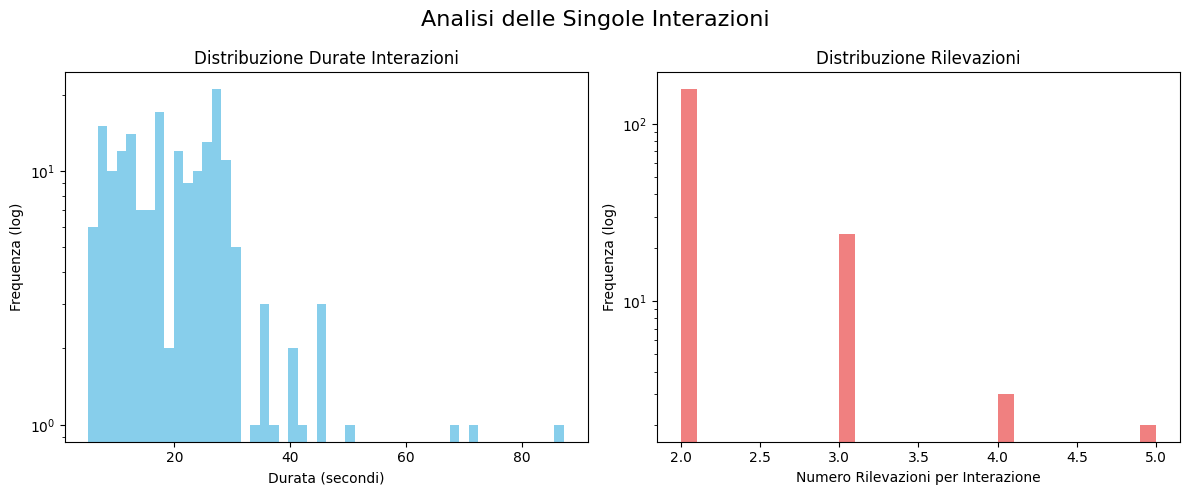



👥 ANALISI DEI DISPOSITIVI
Numero dispositivi analizzati: 60


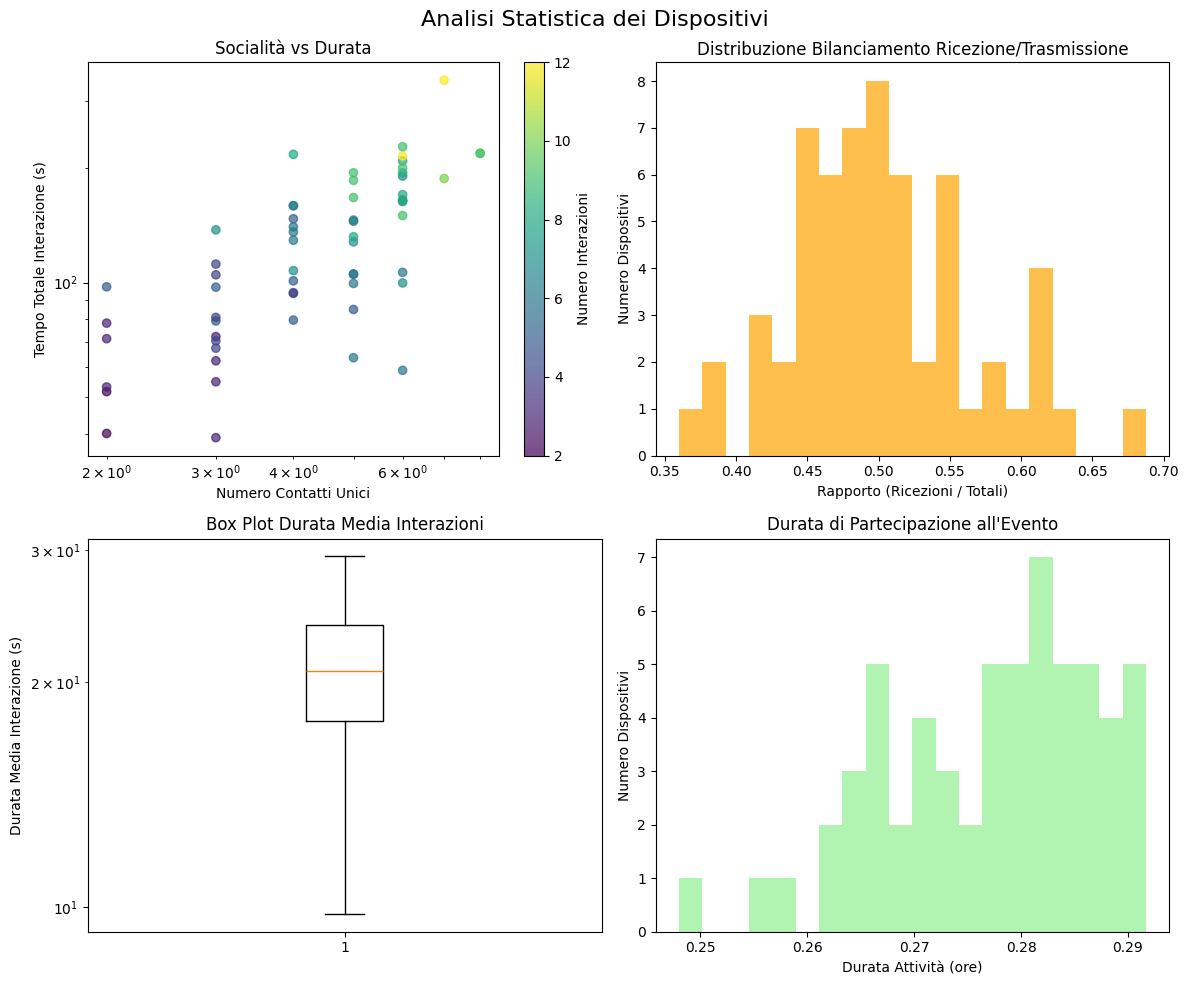



🕸️ ANALISI DELLA RETE SOCIALE


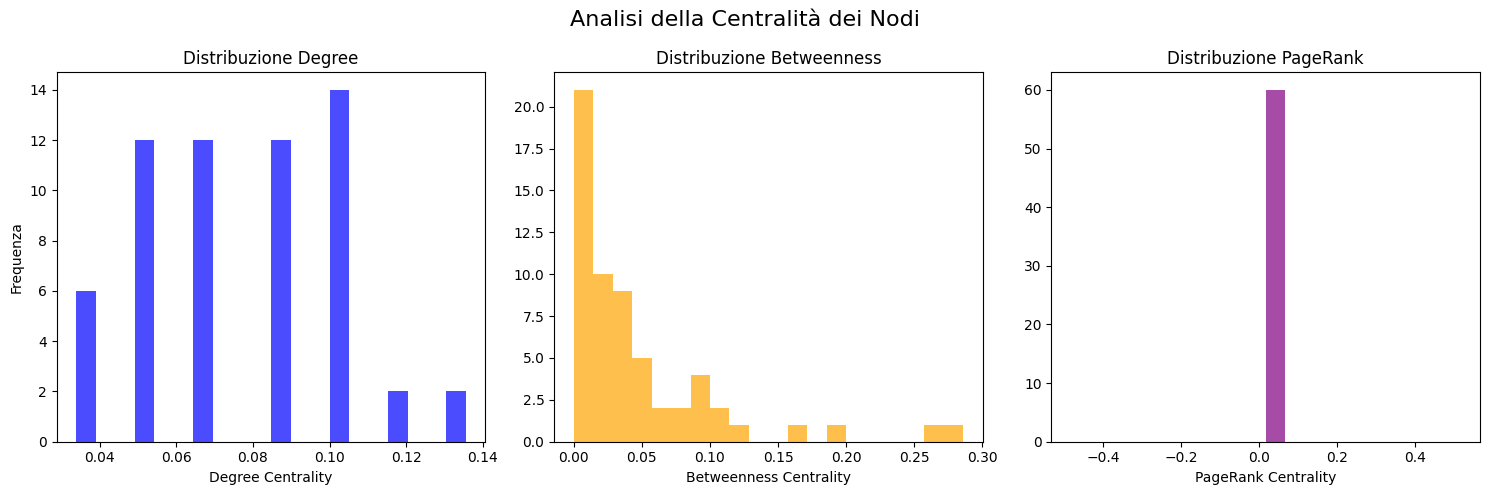



👥 ANALISI DELLE COMUNITÀ
Numero di comunità rilevate: 8
Dimensione media comunità: 7.5
Dimensione comunità più grande: 8


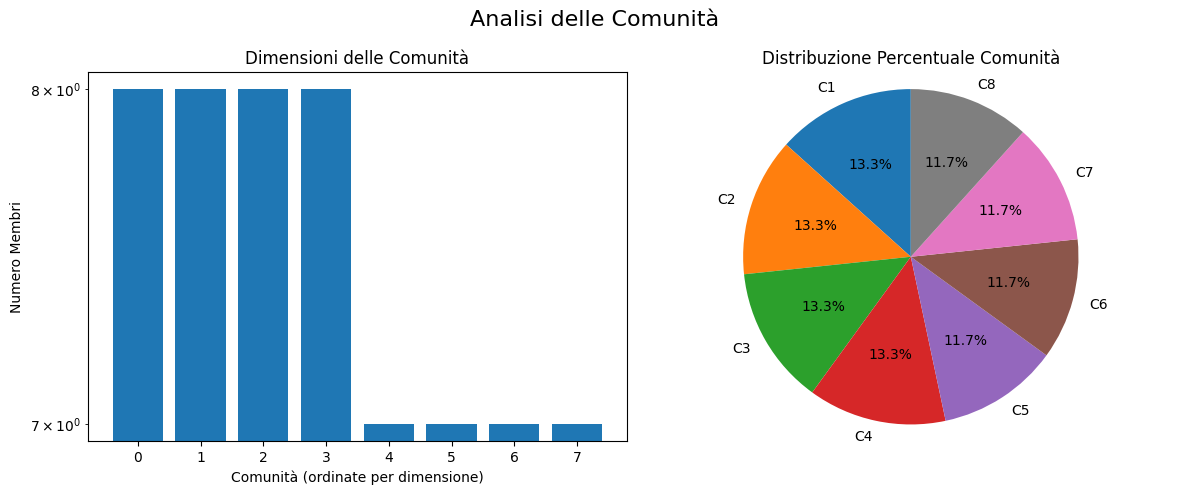


✅ ANALISI ESPLORATIVA COMPLETATA!


In [9]:
# =============================================================================
# ESPLORAZIONE AVANZATA E ROBUSTA DEI RISULTATI
# =============================================================================

# Funzione helper per evitare errori su plot vuoti
def show_plot():
    try:
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Avviso: impossibile mostrare il plot. ({e})")

# =============================================================================
# 1. ANALISI DELLE INTERAZIONI
# =============================================================================
print("📊 ANALISI DELLE INTERAZIONI")
if not interactions.empty:
    print(f"Numero di interazioni processate: {len(interactions)}")
    print(f"Durata media interazione: {interactions['duration'].mean():.1f} secondi")
    print(f"Durata totale di tutte le interazioni: {interactions['duration'].sum()/3600:.2f} ore")

    # Distribuzione delle durate
    plt.figure(figsize=(12, 5))
    plt.suptitle('Analisi delle Singole Interazioni', fontsize=16)

    plt.subplot(1, 2, 1)
    plt.hist(interactions['duration'], bins=50, color='skyblue', log=True)
    plt.xlabel('Durata (secondi)'); plt.ylabel('Frequenza (log)'); plt.title('Distribuzione Durate Interazioni')

    plt.subplot(1, 2, 2)
    plt.hist(interactions['detection_count'], bins=30, color='lightcoral', log=True)
    plt.xlabel('Numero Rilevazioni per Interazione'); plt.ylabel('Frequenza (log)'); plt.title('Distribuzione Rilevazioni')
    show_plot()
else:
    print("Nessuna interazione valida da analizzare.")

# =============================================================================
# 2. ANALISI DEI DISPOSITIVI
# =============================================================================
print("\n\n👥 ANALISI DEI DISPOSITIVI")
if not device_stats.empty:
    print(f"Numero dispositivi analizzati: {len(device_stats)}")

    # Visualizzazioni statistiche sui dispositivi
    plt.figure(figsize=(12, 10))
    plt.suptitle('Analisi Statistica dei Dispositivi', fontsize=16)

    # Subplot 1: Contatti Unici vs Tempo Totale Interazione
    plt.subplot(2, 2, 1)
    plt.scatter(device_stats['unique_contacts'], device_stats['total_interaction_time'], 
               alpha=0.7, c=device_stats['total_interactions'], cmap='viridis')
    plt.xlabel('Numero Contatti Unici'); plt.ylabel('Tempo Totale Interazione (s)'); plt.title('Socialità vs Durata')
    plt.colorbar(label='Numero Interazioni'); plt.xscale('log'); plt.yscale('log')

    # Subplot 2: Distribuzione del rapporto di rilevamento
    plt.subplot(2, 2, 2)
    total_detections = device_stats['detections_as_receiver'] + device_stats['detections_as_transmitter']
    detection_ratio = device_stats['detections_as_receiver'] / total_detections.replace(0, 1) # Evita divisione per zero
    plt.hist(detection_ratio.dropna(), bins=20, alpha=0.7, color='orange')
    plt.xlabel('Rapporto (Ricezioni / Totali)'); plt.ylabel('Numero Dispositivi'); plt.title('Distribuzione Bilanciamento Ricezione/Trasmissione')

    # Subplot 3: Durata media delle interazioni per dispositivo
    plt.subplot(2, 2, 3)
    plt.boxplot(device_stats['avg_interaction_duration'].dropna())
    plt.ylabel('Durata Media Interazione (s)'); plt.title('Box Plot Durata Media Interazioni'); plt.yscale('log')

    # Subplot 4: Durata di attività dei dispositivi
    plt.subplot(2, 2, 4)
    
    # <<< SAFETY NET CHE RISOLVE L'ERRORE >>>
    # Assicurati che le colonne siano di tipo datetime prima di fare calcoli
    first_activity_dt = pd.to_datetime(device_stats['first_activity'], errors='coerce')
    last_activity_dt = pd.to_datetime(device_stats['last_activity'], errors='coerce')
    
    # Ora esegui il calcolo sulle colonne corrette
    active_duration_hours = (last_activity_dt - first_activity_dt).dt.total_seconds() / 3600
    
    plt.hist(active_duration_hours.dropna(), bins=20, alpha=0.7, color='lightgreen')
    plt.xlabel('Durata Attività (ore)'); plt.ylabel('Numero Dispositivi'); plt.title('Durata di Partecipazione all\'Evento')
    
    show_plot()
else:
    print("Nessuna statistica sui dispositivi da analizzare.")

# =============================================================================
# 3. ANALISI DELLE METRICHE DI RETE
# =============================================================================
print("\n\n🕸️ ANALISI DELLA RETE SOCIALE")
if network_metrics and network_metrics.get('nodes') is not None and not network_metrics['nodes'].empty:
    node_metrics = network_metrics['nodes']
    
    # Visualizzazione metriche di centralità
    plt.figure(figsize=(15, 5))
    plt.suptitle('Analisi della Centralità dei Nodi', fontsize=16)
    
    plt.subplot(1, 3, 1)
    plt.hist(node_metrics['degree_centrality'], bins=20, alpha=0.7, color='blue')
    plt.xlabel('Degree Centrality'); plt.ylabel('Frequenza'); plt.title('Distribuzione Degree')

    plt.subplot(1, 3, 2)
    plt.hist(node_metrics['betweenness_centrality'], bins=20, alpha=0.7, color='orange')
    plt.xlabel('Betweenness Centrality'); plt.title('Distribuzione Betweenness')

    plt.subplot(1, 3, 3)
    plt.hist(node_metrics['pagerank_centrality'], bins=20, alpha=0.7, color='purple')
    plt.xlabel('PageRank Centrality'); plt.title('Distribuzione PageRank')
    show_plot()
else:
    print("Nessuna metrica di rete da analizzare.")

# =============================================================================
# 4. ANALISI DELLE COMUNITÀ
# =============================================================================
print(f"\n\n👥 ANALISI DELLE COMUNITÀ")
if communities:
    community_sizes = [len(c) for c in communities if c]
    print(f"Numero di comunità rilevate: {len(community_sizes)}")
    if community_sizes:
        print(f"Dimensione media comunità: {np.mean(community_sizes):.1f}")
        print(f"Dimensione comunità più grande: {max(community_sizes)}")

        # Visualizzazione dimensioni comunità
        plt.figure(figsize=(12, 5))
        plt.suptitle('Analisi delle Comunità', fontsize=16)
        
        plt.subplot(1, 2, 1)
        plt.bar(range(len(community_sizes)), sorted(community_sizes, reverse=True))
        plt.xlabel('Comunità (ordinate per dimensione)'); plt.ylabel('Numero Membri'); plt.title('Dimensioni delle Comunità'); plt.yscale('log')

        plt.subplot(1, 2, 2)
        top_communities = sorted(community_sizes, reverse=True)[:10]
        labels = [f'C{i+1}' for i in range(len(top_communities))]
        if len(community_sizes) > 10:
            labels[-1] = 'Altre...'
            top_communities[-1] = sum(sorted(community_sizes, reverse=True)[9:])
            
        plt.pie(top_communities, labels=labels, autopct='%1.1f%%', startangle=90)
        plt.title('Distribuzione Percentuale Comunità'); plt.axis('equal')
        show_plot()
else:
    print("Nessuna comunità da analizzare.")

print("\n" + "="*80)
print("✅ ANALISI ESPLORATIVA COMPLETATA!")
print("="*80)

In [10]:
analyzer = analyze_iot_data(df)

interactions = analyzer.interactions_df
device_stats = analyzer.device_stats_df
network_metrics = analyzer.network_metrics
communities = analyzer.communities

🔄 Preprocessing delle interazioni...
✅ Trovate 186 interazioni valide
📊 Calcolando statistiche per dispositivo...
🕸️ Creando rete delle interazioni...
📈 Calcolando metriche di rete...
👥 Rilevando comunità...
⏱️ Creando timeline delle interazioni...


🎨 Creando visualizzazione della rete...



📋 REPORT RIASSUNTIVO ANALISI INTERAZIONI IoT

🔍 STATISTICHE GENERALI:
   • Rilevazioni totali: 1,788
   • Dispositivi unici: 60
   • Durata evento: 0.3 ore
   • Media rilevazioni/ora: 6089.6

🤝 INTERAZIONI:
   • Interazioni totali: 186
   • Durata media: 20.9 secondi
   • Interazione più lunga: 87.3 secondi
   • Tempo totale di interazione: 64.7 minuti

🕸️ RETE SOCIALE:
   • Nodi: 60, Archi: 135
   • Densità rete: 0.076
   • Clustering medio: 0.452
   • Componenti connesse: 1
   • Diametro: 8
   • Lunghezza media percorso: 3.68
   • Comunità rilevate: 8

🏆 TOP DISPOSITIVI:
   1. 66fffc05-4e9... - 8 contatti, 219s di interazione
   2. 548dcd41-c18... - 8 contatti, 218s di interazione
   3. 65472b6f-188... - 7 contatti, 340s di interazione
🔗 Analisi dettagliata della connettività...
   📊 Componenti connesse: 1
   🕸️ Densità componente 1: 0.076

